#### 本notebookは『データサイエンスの無駄遣い』（[著]篠田裕之, 翔泳社, 2021）のサンプルコードとなります。

## chapter1：LINEの既読スルーに対してランダムフォレストで立ち向かう。

### 実行検証環境

・Python (3.9.2)

・matplotlib (3.4.1)<br>
・seaborn (0.11.1)<br>
・pandas (1.2.4)<br>
・numpy (1.20.2)<br>
・beautifulsoup4 (4.9.3)<br>
・urllib3 (1.26.4)<br>
・emoji (1.2.0)<br>
・scikit-learn (0.24.2)<br>
・lightgbm (3.2.1)<br>
・imbalanced-learn (0.8.0)<br>
・imblearn (0.0)<br>

### 事前準備

・本書の手順に応じて./dataフォルダにFacebook、LINEのチャット履歴データを保存しておく。

### パッケージのインポート

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
from datetime import datetime as dt
import emoji

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

### データ取得・前処理

#### テキスト中の任意の文字をカウントする関数

In [4]:
def count_char(text, char_list):
    char_count = 0
    for c in text:
        if c in char_list:
            char_count += 1
    return char_count

In [5]:
count_char("ww　完全に寝坊した笑", ["笑","わら","w"])

3

#### チャットデータの各種統計量を返す関数

In [6]:
def get_chat_stat(tmp_df, chat_dir, name):    
    tmp_df[f"text_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["text_len"].mean()
    tmp_df[f"emoji_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["emoji"].mean()
    tmp_df[f"continue_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["continue"].mean()
    tmp_df[f"exclamation_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["exclamation"].mean()
    tmp_df[f"question_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["question"].mean()
    tmp_df[f"laugh_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["laugh"].mean()
    tmp_df[f"reply_{chat_dir}_mean"] = tmp_df[tmp_df["from"] == name]["reply_days"].mean()
    tmp_df[f"text_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["text_len"].max()
    tmp_df[f"emoji_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["emoji"].max()
    tmp_df[f"continue_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["continue"].max()
    tmp_df[f"exclamation_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["exclamation"].max()
    tmp_df[f"question_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["question"].max()
    tmp_df[f"laugh_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["laugh"].max()
    tmp_df[f"reply_{chat_dir}_max"] = tmp_df[tmp_df["from"] == name]["reply_days"].max()    
    
    return tmp_df    

#### 既読スルーの判定(3日以内のレスがないもの)、および特徴量生成のための関数

In [7]:
def get_chat_convert_df(tmp_df, name, my_name):        
    tmp_df['datetime'] = pd.to_datetime(tmp_df['time'])
    tmp_df = tmp_df.sort_values("time").reset_index(drop=True)
    tmp_df["shift_datetime"] = tmp_df["datetime"].shift(-1)
    tmp_df["delta_time"] = tmp_df["shift_datetime"] - tmp_df["datetime"]
    
    text_len_list = []
    emoji_list = []
    ex_list = []
    q_list = []
    laugh_list = []
    continue_list = []
    weekday_list = []
    hour_list = []
    reply_days_list = []
    through_list = []

    tmp_continue_count = 0
    tmp_from = ""
    
    for i in range(len(tmp_df)):
            text_len_list.append(len(tmp_df["text"][i]))
            emoji_list.append(count_char(tmp_df["text"][i], emoji.UNICODE_EMOJI["en"]))
            ex_list.append(count_char(tmp_df["text"][i],["！","!"]))
            q_list.append(count_char(tmp_df["text"][i], ["？","?"]))
            laugh_list.append(count_char(tmp_df["text"][i], ["笑","w"]))

            if (tmp_df["from"][i] == tmp_from) and (i != 0):
                tmp_continue_count += 1
            else:
                tmp_continue_count = 0
            tmp_from = tmp_df["from"][i]

            continue_list.append(tmp_continue_count)            

            hour_list.append(tmp_df["datetime"][i].hour)
            weekday_list.append(tmp_df["datetime"][i].weekday())

            reply_days_list.append(tmp_df["delta_time"][i].days)        
            
            #既読スルーの判定
            if tmp_df["delta_time"][i].days > 3:
                tmp_through = 1
            else:
                tmp_through = 0

            through_list.append(tmp_through)    
    
    tmp_df["text_len"] = text_len_list
    tmp_df["emoji"] = emoji_list
    tmp_df["exclamation"] = ex_list
    tmp_df["question"] = q_list
    tmp_df["laugh"] = laugh_list
    tmp_df["continue"] = continue_list
    tmp_df["hour"] = hour_list
    tmp_df["weekday"] = weekday_list
    tmp_df["reply_days"] = reply_days_list
    tmp_df["through"] = through_list            
        
    #相手からのチャットの特徴量
    tmp_df = get_chat_stat(tmp_df, "from", name)
    
    #自分からのチャットの特徴量
    tmp_df = get_chat_stat(tmp_df, "to", name)

    tmp_df["message_days"] = (tmp_df["datetime"][len(tmp_df)-1] - tmp_df["datetime"][0]).days
    tmp_df["message_count"] = len(tmp_df)    
    
    return tmp_df

#### LINEのチャットデータを整形するための関数

In [8]:
def make_line_message_df(name, my_name, text):
    f = open(text, 'r', encoding='utf-8')
    line_data = f.readlines()
    f.close()    
    
    tmp_day = ""
    tmp_time = ""
    tmp_from = ""
    tmp_text = ""

    daytime_list = []
    from_list = []
    text_list = []

    count = 0
    
    for text in line_data:        
        if ("とのトーク履歴" in text) or ("保存日時" in text):
            continue

        if len(text) == 14:
            if (text[4] == "/") and (text[7] == "/") and (text[10] == "("):
                #もしメッセージが格納されていれば前の時刻までのメッセージを格納
                if len(tmp_text) > 1:
                    daytime_list.append(tmp_day + " " + tmp_time)
                    from_list.append(tmp_from)                
                    tmp_text = tmp_text.replace("\n","")                
                    text_list.append(tmp_text)
                    
                tmp_text = ""                    
                tmp_day = text[:-4]    
                continue

        if len(text) > 5:
            if text[2] == ":" and text[5] == '\t':
                #もしメッセージが格納されていれば前の時刻までのメッセージを格納
                if len(tmp_text) > 1:
                    daytime_list.append(tmp_day + " " + tmp_time)
                    from_list.append(tmp_from)                
                    tmp_text = tmp_text.replace("\n","")                
                    text_list.append(tmp_text)
                
                split_text = text.split("\t")
                tmp_time = split_text[0]
                tmp_from = split_text[1]
                tmp_text = split_text[2]                
                continue
                                
        #時刻付きの行ではない（前の時刻のメッセージの続きなら前のテキストに続ける）
        tmp_text = tmp_text + text
        
    #最後のメッセージを加える
    daytime_list.append(tmp_day + " " + tmp_time)
    from_list.append(tmp_from)                
    tmp_text = tmp_text.replace("\n","")                
    text_list.append(tmp_text)
        
    tmp_df = pd.DataFrame({
                                'from':from_list, 
                                'text':text_list,
                                'time':daytime_list    
                    })
    
    tmp_df["thread"] = name
            
    tmp_df = get_chat_convert_df(tmp_df, name, my_name)
    
    #最後の行は削除（スレッドの最後は返信がないため）
    tmp_df = tmp_df[:-1]
    
    return tmp_df

#### Facebookのチャットデータを整形するための関数

In [9]:
def make_message_df(name, my_name, url_list):
    for i in range(len(url_list)):
        #print(url_list[i])
        #print(i)
        html = open(url_list[i], 'r', encoding='utf-8')
        soup = BeautifulSoup(html, 'html.parser')

        from_classes = soup.find_all(class_="_3-96 _2pio _2lek _2lel")
        text_classes = soup.find_all(class_="_3-96 _2let")
        time_classes = soup.find_all(class_="_3-94 _2lem")    

        from_list = []
        text_list = []
        time_list = []

        for k in range(len(from_classes)):
                from_list.append(from_classes[k].text)
                text_list.append(text_classes[k].text)
                time_list.append(time_classes[k].text)

        if i == 0:
            tmp_df = pd.DataFrame({
                            'from':from_list, 
                            'text':text_list,
                            'time':time_list
                             })        
        else:
            tmp_df2 = pd.DataFrame({
                            'from':from_list, 
                            'text':text_list,
                            'time':time_list
                             })        
            
            tmp_df = pd.concat([tmp_df, tmp_df2]).reset_index(drop=True)            
                        
    tmp_df["thread"] = name
            
    tmp_df = get_chat_convert_df(tmp_df, name, my_name)
    
    #最後の行は削除（スレッドの最後は返信がないため）
    tmp_df = tmp_df[:-1]
    
    return tmp_df

#### LINEとFacebookのチャットデータの整形（./dataフォルダ内に分析したいチャット相手のログを取得しておく）

※GitHub(https://github.com/mirandora/ds_book/tree/main/1_1) に公開しているものはコード動作確認用に作成した架空のダミーデータとなります。

In [10]:
user_A_df = make_line_message_df("UserA","HiroyukiS","./data/user_a.txt") #LINEデータの場合
user_B_df = make_message_df("user_b","Hiroyuki Shinoda", ["./data/user_b.html"]) #Facebookデータの場合
user_C_df = make_message_df("user_c","Hiroyuki Shinoda", ["./data/user_c.html"]) #Facebookデータの場合
user_D_df = make_message_df("user_d","Hiroyuki Shinoda", ["./data/user_d.html"]) #Facebookデータの場合

In [11]:
all_df = pd.concat([user_A_df, user_B_df, user_C_df, user_D_df]).reset_index(drop=True)

In [12]:
all_df

,from,text,time,thread,datetime,shift_datetime,delta_time,text_len,emoji,exclamation,...,reply_to_mean,text_to_max,emoji_to_max,continue_to_max,exclamation_to_max,question_to_max,laugh_to_max,reply_to_max,message_days,message_count
0,UserA,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊...,2018/07/07 12:40,UserA,2018-07-07 12:40:00,2018-07-07 13:37:00,0 days 00:57:00,144,4,0,...,1.075175,526,8,5,13,7,10,181.0,889,1006
1,HiroyukiS,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊...,2018/07/07 13:37,UserA,2018-07-07 13:37:00,2018-07-07 17:13:00,0 days 03:36:00,117,4,1,...,1.075175,526,8,5,13,7,10,181.0,889,1006
2,UserA,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊...,2018/07/07 17:13,UserA,2018-07-07 17:13:00,2018-07-07 17:37:00,0 days 00:24:00,163,5,1,...,1.075175,526,8,5,13,7,10,181.0,889,1006
3,HiroyukiS,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊...,2018/07/07 17:37,UserA,2018-07-07 17:37:00,2018-07-07 17:38:00,0 days 00:01:00,84,4,1,...,1.075175,526,8,5,13,7,10,181.0,889,1006
4,UserA,＊＊＊＊＊＊＊＊＊＊＊！？？,2018/07/07 17:38,UserA,2018-07-07 17:38:00,2018-07-07 17:38:00,0 days 00:00:00,14,0,1,...,1.075175,526,8,5,13,7,10,181.0,889,1006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,Hiroyuki Shinoda,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊笑笑,2020/09/15 12:02,user_d,2020-09-15 12:02:00,2020-09-15 13:31:00,0 days 01:29:00,44,0,0,...,0.403532,316,0,10,4,3,12,630.0,2489,5540
7522,user_d,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊,2020/09/15 13:31,user_d,2020-09-15 13:31:00,2020-09-15 13:31:00,0 days 00:00:00,17,0,0,...,0.403532,316,0,10,4,3,12,630.0,2489,5540
7523,user_d,＊＊＊＊笑,2020/09/15 13:31,user_d,2020-09-15 13:31:00,2020-09-15 13:32:00,0 days 00:01:00,5,0,0,...,0.403532,316,0,10,4,3,12,630.0,2489,5540
7524,user_d,＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊！,2020/09/15 13:32,user_d,2020-09-15 13:32:00,2020-09-15 19:46:00,0 days 06:14:00,41,0,1,...,0.403532,316,0,10,4,3,12,630.0,2489,5540


### データ分析(EDA)

#### 曜日・時間帯ごとのチャット数、既読スルー率のヒートマップを作成

In [13]:
through_count = all_df[(all_df["from"] == "Hiroyuki Shinoda") | (all_df["from"] == "HiroyukiS")].groupby(["weekday","hour"])[["through"]].sum().reset_index()
message_count = all_df[(all_df["from"] == "Hiroyuki Shinoda") | (all_df["from"] == "HiroyukiS")].groupby(["weekday","hour"])[["text"]].count().reset_index()

In [14]:
weekhour_df = pd.merge(through_count,message_count,on=["weekday","hour"],how="left")

In [15]:
weekhour_df["through_rate"] = weekhour_df["through"]/weekhour_df["text"]

In [16]:
weekhour_df.loc[weekhour_df["weekday"] == 0, "weekday"] = "mon"
weekhour_df.loc[weekhour_df["weekday"] == 1, "weekday"] = "tue"
weekhour_df.loc[weekhour_df["weekday"] == 2, "weekday"] = "wed"
weekhour_df.loc[weekhour_df["weekday"] == 3, "weekday"] = "thu"
weekhour_df.loc[weekhour_df["weekday"] == 4, "weekday"] = "fri"
weekhour_df.loc[weekhour_df["weekday"] == 5, "weekday"] = "sat"
weekhour_df.loc[weekhour_df["weekday"] == 6, "weekday"] = "sun"

In [17]:
weekhour_df

,weekday,hour,through,text,through_rate
0,mon,0,0,9,0.000000
1,mon,1,0,9,0.000000
2,mon,2,1,6,0.166667
3,mon,6,0,3,0.000000
4,mon,7,0,1,0.000000
...,...,...,...,...,...
126,sun,19,0,3,0.000000
127,sun,20,0,6,0.000000
128,sun,21,0,13,0.000000
129,sun,22,0,4,0.000000


<AxesSubplot:xlabel='weekday', ylabel='hour'>

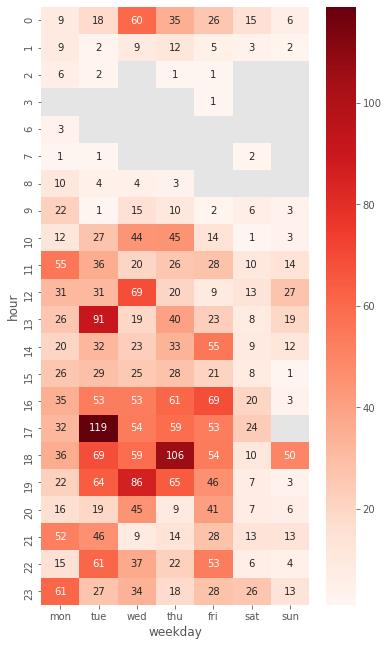

In [18]:
df_hour_pivot = weekhour_df.pivot(index="hour",columns="weekday",values="text")
df_hour_pivot = df_hour_pivot[["mon","tue","wed","thu","fri","sat","sun"]]
plt.figure(figsize=(6,11))
sns.heatmap(df_hour_pivot, annot=True, fmt='.0f',cmap='Reds')

<AxesSubplot:xlabel='weekday', ylabel='hour'>

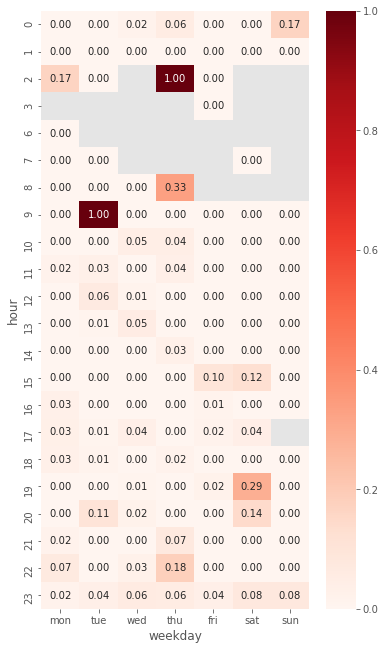

In [19]:
df_hour_rate_pivot = weekhour_df.pivot(index="hour",columns="weekday",values="through_rate")
df_hour_rate_pivot = df_hour_rate_pivot[["mon","tue","wed","thu","fri","sat","sun"]]
plt.figure(figsize=(6,11))
sns.heatmap(df_hour_rate_pivot, annot=True, fmt='.2f',cmap='Reds')

#### 相関係数の一覧を表示

In [20]:
thread_mean = all_df.groupby(["thread"]).max()[["message_days","message_count","text_from_mean","emoji_from_mean",
                                                "continue_from_mean",'exclamation_from_mean',"question_from_mean",
       'laugh_from_mean','reply_from_mean']]

In [21]:
thread_through = all_df[(all_df["from"] == "Hiroyuki Shinoda") | (all_df["from"] == "HiroyukiS")].groupby(["thread"]).sum()[["through"]]

In [22]:
thread_df = pd.merge(thread_mean, thread_through,  left_index=True, right_index=True,how="left")

In [23]:
thread_df["through_rate"] = thread_df["through"]/thread_df["message_count"]

In [24]:
thread_df = thread_df.drop(["through"],axis=1)

<AxesSubplot:>

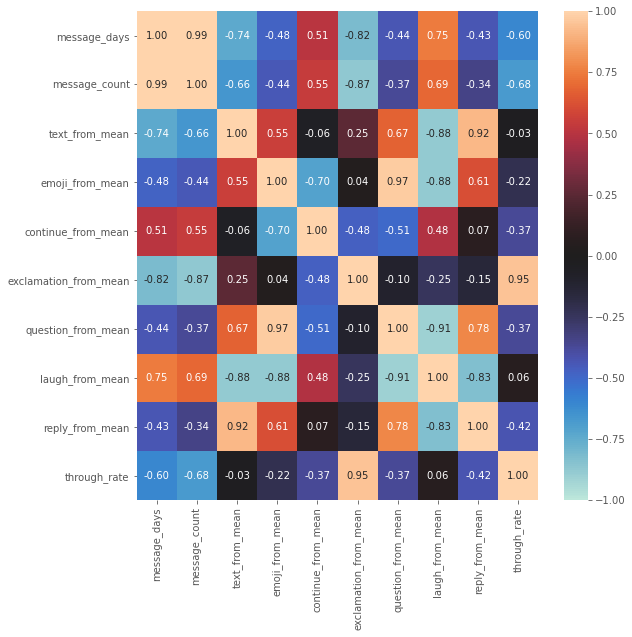

In [25]:
thread_corr = thread_df.corr()
plt.figure(figsize=(9, 9))
sns.heatmap(thread_corr, vmax=1, vmin=-1, center=0, annot=True, fmt=".2f")

#### ユーザごとのチャット履歴の可視化

・各ユーザ相手ごとのチャット文字数のプロット（自分から送信したチャットのみ）

<AxesSubplot:xlabel='text_len', ylabel='thread'>

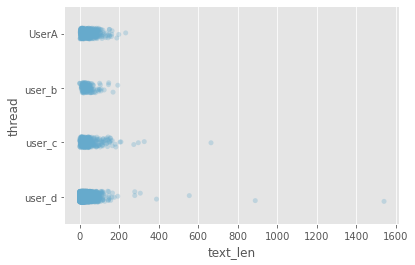

In [26]:
sns.stripplot(x='text_len', y='thread', color="#66aacc", alpha =0.3 ,data=all_df[(all_df["from"] == "Hiroyuki Shinoda") | (all_df["from"] == "HiroyukiS")])

・各ユーザ相手ごとのチャット文字数および既読スルー（赤）のプロット（自分から送信したチャットのみ）

<AxesSubplot:xlabel='text_len', ylabel='thread'>

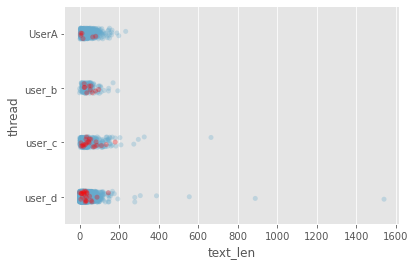

In [27]:
sns.stripplot(x='text_len', y='thread', color="#66aacc", alpha =0.3 ,data=all_df[(all_df["from"] == "Hiroyuki Shinoda") | (all_df["from"] == "HiroyukiS")])
sns.stripplot(x='text_len', y='thread', color="red", alpha =0.3 ,data=all_df[((all_df["from"] == "Hiroyuki Shinoda") | (all_df["from"] == "HiroyukiS")) & (all_df["through"] == 1)])

### 既読スルーを機械学習

今回、ランダムスプリットするのではなく、ある時点までのデータをtrain、以降のデータをtestデータ、とするため独自にデータ分割する関数を定義

In [28]:
def split_train_test(df, ratio):
    split_idx = int(len(df) * ratio)
    train_df = df[:split_idx]
    test_df = df[split_idx:].reset_index(drop=True)
    
    return train_df, test_df

In [29]:
userA_train , userA_test = split_train_test(user_A_df, 0.8)
userB_train , userB_test = split_train_test(user_B_df, 0.8)
userC_train , userC_test = split_train_test(user_C_df, 0.8)
userD_train , userD_test = split_train_test(user_D_df, 0.8)

In [30]:
train_df = pd.concat([userA_train, userB_train, userC_train, userD_train]).reset_index(drop=True)
test_df = pd.concat([userA_test, userB_test, userC_test, userD_test]).reset_index(drop=True)

自分から送信したログのみを抽出

In [31]:
train_df_proc = train_df[(train_df["from"] == "Hiroyuki Shinoda") | (train_df["from"] == "HiroyukiS")].reset_index(drop=True)
train_df_proc = train_df_proc.drop(["from","text","time","datetime","shift_datetime","delta_time","reply_days"],axis=1)

In [32]:
test_df_proc = test_df[(test_df["from"] == "Hiroyuki Shinoda") | (test_df["from"] == "HiroyukiS")].reset_index(drop=True)
test_df_proc = test_df_proc.drop(["from","text","time","datetime","shift_datetime","delta_time","reply_days"],axis=1)

In [33]:
le = LabelEncoder()
le = le.fit(train_df["thread"])
train_df_proc["thread"] = le.transform(train_df_proc["thread"])
test_df_proc["thread"] = le.transform(test_df_proc["thread"])

In [34]:
train_df_proc["thread_through"] = train_df_proc["thread"].astype(str) + "_" + train_df_proc["through"].astype(str)
test_df_proc["thread_through"] = test_df_proc["thread"].astype(str) + "_" + test_df_proc["through"].astype(str)

In [35]:
train_X = train_df_proc.drop(["through"],axis=1)
train_Y = train_df_proc["through"]

In [36]:
folds = 3
skf = StratifiedKFold(n_splits=folds)

In [37]:
categories = ["thread","weekday"]

In [38]:
lgbm_params = {
    "objective":"binary",
    "metric": "auc",
    'num_leaves': 53,
    'max_bin': 91,
    'bagging_fraction': 0.41233936419566564,
    'bagging_freq': 6,
    'feature_fraction': 0.771917272654894,
    'min_data_in_leaf': 4,
    'min_sum_hessian_in_leaf': 1,
    "random_seed":1234,
    "verbose":-1,        
}

In [39]:
models = []
for train_index, val_index in skf.split(train_X,train_X["thread_through"]):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    X_train = X_train.drop(["thread_through"],axis=1)
    X_valid = X_valid.drop(["thread_through"],axis=1)
    
    #ランダムにアンダーサンプリング(比率を指定)
    train_through = y_train.sum()
    rus = RandomUnderSampler(sampling_strategy = {0:train_through*4, 1:train_through}, random_state=0)
    X_train_rs, y_train_rs = rus.fit_resample(X_train, y_train)
    
    valid_through = y_valid.sum()
    rus = RandomUnderSampler(sampling_strategy = {0:valid_through*4, 1:valid_through}, random_state=0)
    X_valid_rs, y_valid_rs = rus.fit_resample(X_valid, y_valid)
    
    lgb_train = lgb.Dataset(X_train_rs, y_train_rs, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_valid_rs, y_valid_rs, categorical_feature=categories, reference=lgb_train)
    model_lgb = lgb.train(lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=50,
        early_stopping_rounds=10,
        verbose_eval=10,
    )
    
    y_pred = model_lgb.predict(X_valid_rs, num_iteration=model_lgb.best_iteration)
    print("accuracy",accuracy_score(y_valid_rs, np.round(y_pred)))
    print("auc",roc_auc_score(y_valid_rs, y_pred))
    models.append(model_lgb)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.699704
Early stopping, best iteration is:
[2]	valid_0's auc: 0.731509
accuracy 0.8
auc 0.7315088757396451
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.813965
[20]	valid_0's auc: 0.853027
[30]	valid_0's auc: 0.791504
Early stopping, best iteration is:
[20]	valid_0's auc: 0.853027
accuracy 0.8375
auc 0.85302734375
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.787778
Early stopping, best iteration is:
[4]	valid_0's auc: 0.795
accuracy 0.8
auc 0.795


/Users/hdymacuser/.pyenv/versions/miniforge3-4.10/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/hdymacuser/.pyenv/versions/miniforge3-4.10/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/hdymacuser/.pyenv/versions/miniforge3-4.10/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/Users/hdymacuser/.pyenv/versions/miniforge3-4.10/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/hdymacuser/.pyenv/versions/miniforge3-4.10/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Ove

※架空のダミーデータでの実行のため、モデリングは本書に掲載の実データに行ったものと比較して不十分な状態となっている点に留意。

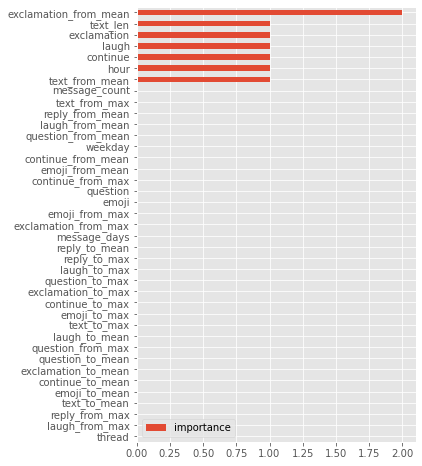

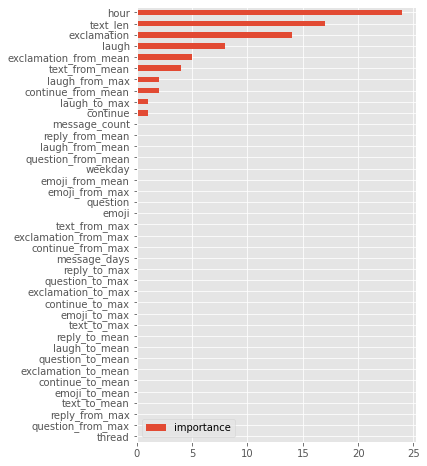

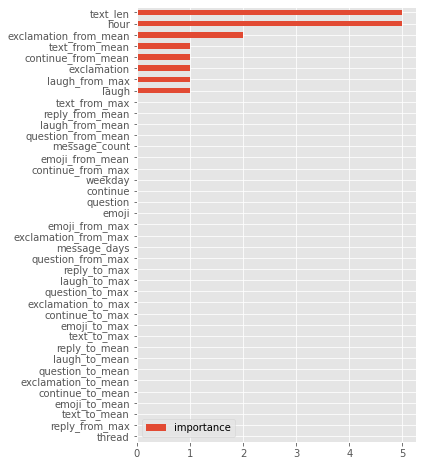

In [40]:
for model in models:
    importance = pd.DataFrame(model.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending =True)
    importance.plot.barh(figsize=(5,8))

In [41]:
preds = []
for model in models:
    test_X = test_df_proc.drop(["through","thread_through"],axis=1)
    test_Y = test_df_proc["through"]
    
    pred = model.predict(test_X)
    print("accuracy",accuracy_score(test_Y, np.round(pred)))
    print("auc",roc_auc_score(test_Y, pred))
    preds.append(pred)    

accuracy 0.9760900140646976
auc 0.7088489574504153
accuracy 0.9282700421940928
auc 0.7894558399728768
accuracy 0.9760900140646976
auc 0.7383031022207154
